In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
dat = np.loadtxt("rand_points.txt")

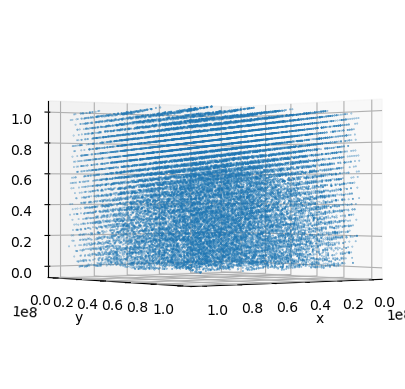

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*dat.T, s= .1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0, azim=52, roll = 0)


# vanilla python realization

In [4]:
import random

random.seed(1024)
pyrand = np.array([random.randint(1, 1e8) for _ in range(10002)])
pyrand3 = pyrand.reshape((-1,3));

# 3D plotting

Text(0.5, 0, 'z')

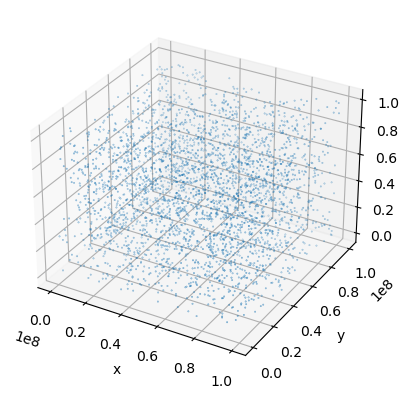

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*pyrand3.T, s= .1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


**I played around with the view points and I didn't find any particular correlations visually...**

# Fourier transform of series
I am not sure whether this would be helpful or not... But I think FFT can definitely be used to evaluate PRNG at a correlation level.

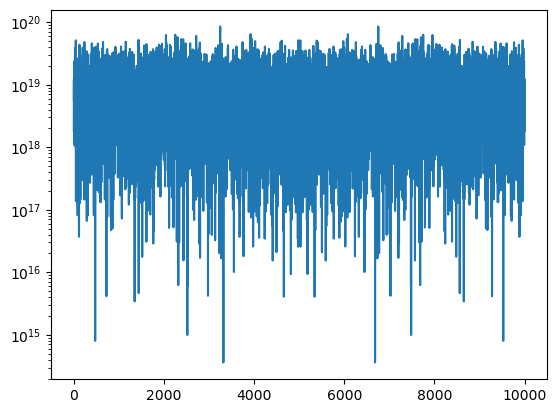

In [6]:
F3py = np.abs(np.fft.fft(pyrand)**2)
plt.plot(F3py[1:])
plt.yscale('log')

## There doesn't seem to be any correlations in particular. The power spectrum is pretty white...

# Pulling the C standard library on my PC
Borrowing Jon's code


In [7]:
import numpy as np
import ctypes
import numba as nb
import time
from matplotlib import pyplot as plt

mylib=ctypes.cdll.LoadLibrary("libc.dylib")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int


@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

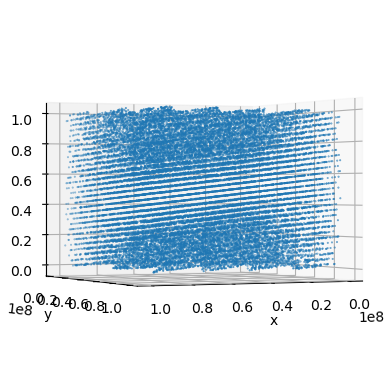

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*vv2.T, s= .2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0, azim=65, roll = 0)

We can still see correlated x,y,z numbers.

# Question 2: Rejection

Rejection requires our drawing distribution to cover the distribution we want.

WLOG, let $\lambda$ = 1 in exponential. 

Gaussian is not heavy-tailed... Expect it to not work.

Power law decay is slower than exponential: $$\lim_{x\rightarrow\infty} \frac{\text{Power Law}}{\text{exp}^{-x}}\rightarrow\infty$$
Hence we expect it to cover.

Lortentzian is similar: $$\lim_{x\rightarrow\infty} \frac{1/(1+x^2)}{\text{exp}^{-x}}\rightarrow\infty$$

**Caveat:** For power law, we need to shift the cut off since the CDF of $\alpha x^{-k}$ blows up at 0. Hence, $P_{\text{pow}}=a(x-x_0)^{-k}$.

First plot all four PDFs.


In [9]:
def gau(x, a, s):
    return a * np.exp(-1/2*x**2/s**2)

def power(x, a, x0, k):
    return a*(x+x0)**(-k)

def lor(x, a, g):
    return a/(1+x**2/g**2)

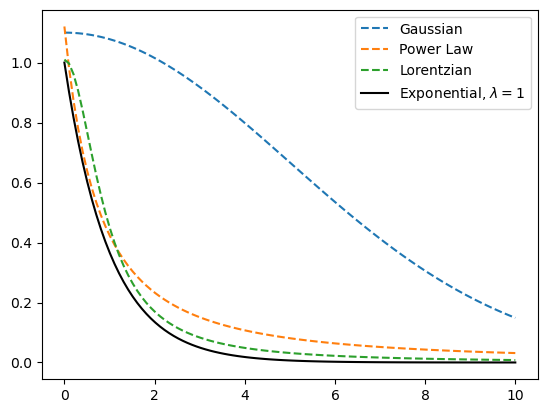

In [10]:
xx = np.linspace(0,10, 100)

pg=[1.1, 5]
pp = [1.5, 1.2, 1.6]
pl = [1.01, 0.9]


plt.plot(xx , gau(xx, *pg), ls = '--', label = 'Gaussian')
plt.plot(xx , power(xx, *pp), ls = '--', label = "Power Law")
plt.plot(xx , lor(xx, *pl), ls = '--', label = 'Lorentzian')
plt.plot(xx, np.exp(-xx), c= 'k', label ="Exponential, $\lambda = 1$")
plt.legend()

**let's look at some higher x interval and see if exponential is still covered.**

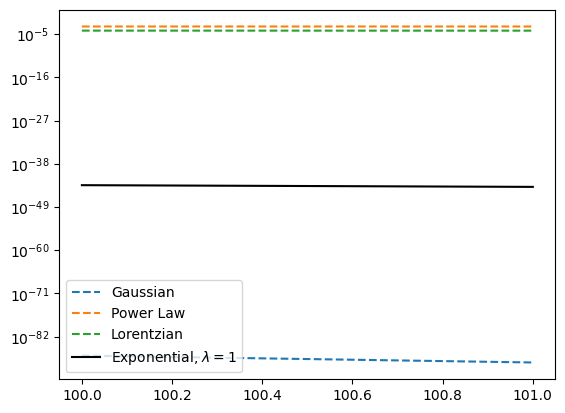

In [11]:
xx = np.linspace(100,101, 100)

plt.plot(xx , gau(xx, *pg), ls = '--', label = 'Gaussian')
plt.plot(xx , power(xx, *pp), ls = '--', label = "Power Law")
plt.plot(xx , lor(xx, *pl), ls = '--', label = 'Lorentzian')
plt.plot(xx, np.exp(-xx), c= 'k', label ="Exponential, $\lambda = 1$")
plt.yscale('log')
plt.legend()

**The Gaussian is GONE.** But the other still holds. Therefore, we can use the two heavy-tailed distributions to generate exponential deviates.

# To start off, we need to find the CDF to generate Lorentzian and Power Law (the two are **NOT** normalized). 

Integrating out to get the CDF for Lorentzian:
$$F_{\text{lor}} = a\ g \text{Arctan}(\frac{x}{g})$$


Integrating out to get the CDF for Power law:
$$F_{\text{P.L.}} = \frac{(y (x+y))^{-k} \left(a y (x+y)^k-a y^k (x+y)\right)}{k-1}$$
for $f(x) = a\ (x+y)^{-k}, \{k,y\}> 0$

Invert both functions to get $x$ as a function of $F\in[0,1]$. 
For Cauchy distribution:
$$x = g \text{Tan}[\frac{X}{a\ g}], X\in[0,1]$$
For Power Law distribution, I didn't solve for general case. For amplitude = 1.1, shift = 1.2, k=1.6, Numerically I got $$x=\frac{2.74622\, -1.2 (1.64336-X))^{5/3}}{((1.64336-X))^{5/3}}$$.

**One could argue doing this numerically is inaccurate. But if you revert the whole procedure numercically, you still get a power law back with exactly the same exponent.**

In [12]:
icdfP = lambda x: (2.74622-1.2*(1.64336-x)**(5/3))/(1.64336-x)**(5/3)
icdfL = lambda x, a, g: g*np.tan(x/a/g)

"CDF" values no longer lie in $[0,1]$ since I didn't normalize. I need to add a constant when inverting.
For Lorentzian, taking limit $x\rightarrow \infty, F_{\text{lor}}\rightarrow\frac{ag\pi}{2}$, the "CDF" falls into $[0,\pi a g/2]$ uniformly.

Similarly, for the power law, the "CDF" falls into $[0, 1.64336]$ uniformly.

Therefore, we should draw our cumulative value $X$ from these intervals.

The red curve shows the rescaled original functions normalized by the amplitude of the histograms at zero.

Text(0.5, 0, 'x')

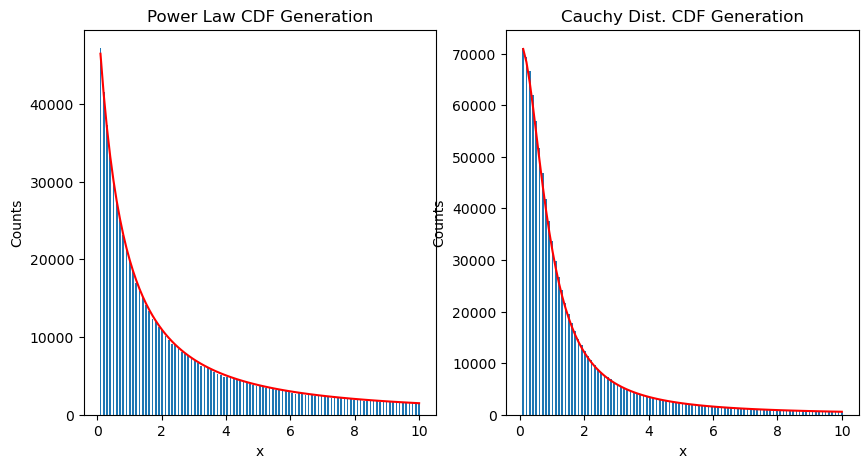

In [13]:
upow = np.random.rand(1000000) *1.64336;
ulor = np.random.rand(1000000) *pl[0] * pl[1] * np.pi/2;

yypow = icdfP(upow)
yylor = icdfL(ulor,*pl)

bins = np.linspace(0,10,100)

ypow, xpow = np.histogram(yypow, bins)
xpow = np.diff(xpow) + xpow[:-1]
ylor, xlor = np.histogram(yylor, bins)
xlor = np.diff(xlor) + xlor[:-1]

fig = plt.figure(figsize = (10,5))
axes = fig.subplots(1,2).flatten()

xx = np.linspace(0,6, 1000)
axes[0].bar(xpow, ypow, .05)
axes[0].plot(xpow, power(xpow, *pp)*ypow.max(),c ='r')
axes[1].bar(xlor, ylor, .05)
axes[1].plot(xpow, lor(xlor, *pl)*ylor.max(),c ='r')
axes[0].set_title('Power Law CDF Generation')
axes[1].set_title('Cauchy Dist. CDF Generation')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('x')
axes[1].set_ylabel('Counts')
axes[1].set_xlabel('x')

**This shows that using the CDF, we can analytically generate Cauchy and power law distributions. Now we try rejection to get exponential**
The procedure is that:
* Generate a number u within range of "CDF" (un-normalized) from a uniform distribution
* Calculate the x = CDF$^{-1}$(u).

(**We have done these two steps** )

* Calculate the PDF (un-normalized) $P(x)$
* Take the ratio $R = \frac{\text{exp}^{-x}}{P(x)}$. Generate another random number $z\in[0,1]$
    * Note that $R\in[0,1]$ if the distribution we want to generate is bounded.
* If $z < R$, accept x. If $z>R$, reject x.

## Lorentzian realization

Text(0.5, 0, '$X$')

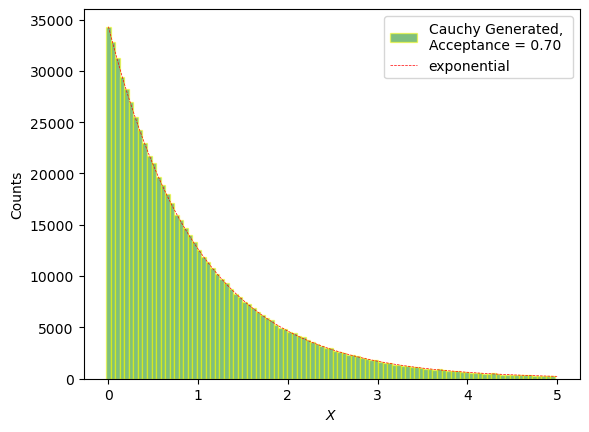

In [15]:
xx = np.linspace(0,5, 100)
pdflor = lor(yylor, *pl)
Rlor = np.exp(-yylor)/pdflor
pcondlor = np.random.rand(len(Rlor))< Rlor

clor, _, __ =plt.hist(yylor[pcondlor], xx, align = 'left', lw = 1, alpha = .5,ec="yellow", fc="green",
                     label = f'Cauchy Generated, \nAcceptance = {np.sum(pcondlor)/len(Rlor):.2f}')

plt.plot(xx, np.exp(-xx)*clor.max(), 'r--', label = 'exponential', lw = .5)
plt.legend()
plt.ylabel('Counts')
plt.xlabel('$X$')

# Power law realization

Text(0.5, 0, '$X$')

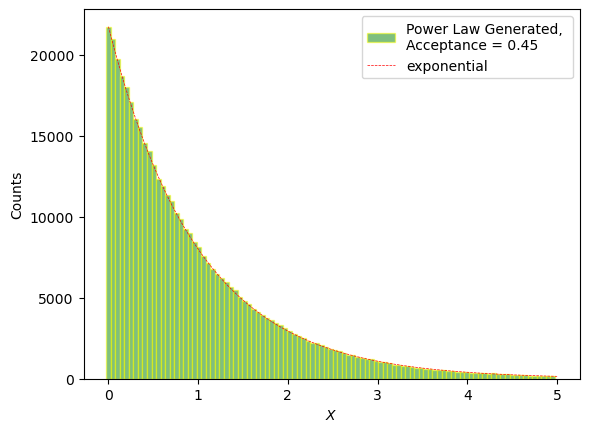

In [16]:
pdfpow = power(yypow, *pp)
Rpow = np.exp(-yypow)/pdfpow
pcondpow = np.random.rand(len(Rpow))< Rpow

cpow, _, __ = plt.hist(yypow[pcondpow],xx, align = 'left', lw = 1, alpha = .5,ec="yellow", fc="green",
                     label = f'Power Law Generated, \nAcceptance = {np.sum(pcondpow)/len(Rlor):.2f}')

plt.plot(xx, np.exp(-xx)*cpow.max(), 'r--', label = 'exponential', lw = .5)
plt.legend()
plt.ylabel('Counts')
plt.xlabel('$X$')

We can tune the parameters in `pl` and `pp` to get a smaller difference bewteen area under the curve for Exp and Lor. (or Power Law), without violating that $R\leq1$.
This can be achieved by maximizing the integral $$\int_0^{\infty}dx R(x) P(x)$$, where $$R=\frac{f(x)}{P(x)}.$$
$f(x)$ is the distribution we want to generate and $P(x)$ is the distribution we want to draw from.

# Question 3: ratio of uniforms

This method transforms the PDF on positive real axis to region bounding $$0<u<\sqrt{P(v/u)}.$$ This mapping is direct since Jacobian is constant.

Plug in $X=v/u$ for $P(x) =\text{exp}(-x)$, we get $v=-2\ u\ \text{log}(u)$

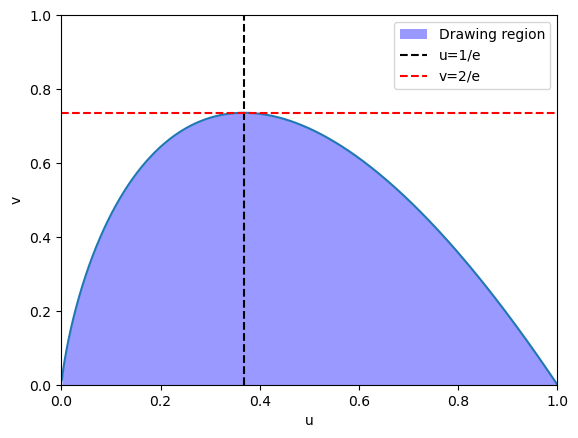

In [17]:
u = np.linspace(0,1, 1001)[1:]
v = -2*u*np.log(u)
plt.plot(u,v)
plt.axis([0,1,0,1])
plt.ylabel('v')
plt.xlabel('u')
plt.fill_between(u,v,color='blue',alpha=.4, lw = 0, label = 'Drawing region')
plt.axvline(1/np.e, color= 'k', ls = '--', label = 'u=1/e')
plt.axhline(2/np.e, color= 'r', ls = '--', label = 'v=2/e')
plt.legend()

To maximize efficiency, we generate $v$ with a bound smaller than $[0,1]$. 

Maximize to get $v(u)= 2/e$ by setting $v'(u)=0$, where $e$ is the natural number.

The acceptance rate is $$\frac{\int_0^{1}du v(u)}{v_{\text{max}}\cdot u_{\text{max}}}=\frac{1/2}{2/e} = \frac{e}{4}\approx0.6796$$

Text(0.5, 0, 'X')

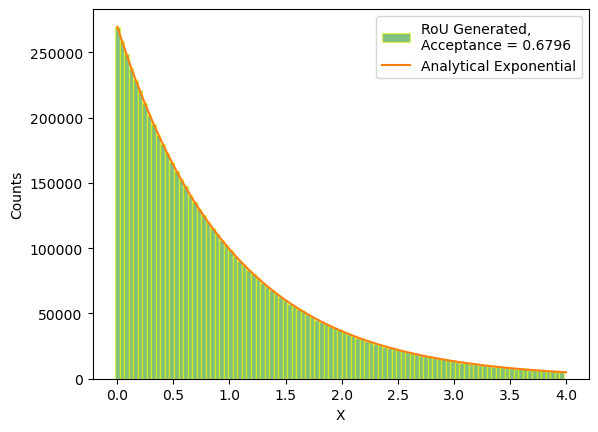

In [18]:
ns = 10000000
uu = np.random.rand(ns)
vv = np.random.rand(ns)*(2/np.e)
cond = uu<np.exp(-0.5*vv/uu)
sample = (vv/uu)[cond]
xx = np.linspace(0,4,100)
count, _, __ = plt.hist(sample, xx, align = 'left', lw = 1, alpha = .5,ec="yellow", fc="green",
                     label = f'RoU Generated, \nAcceptance = {np.sum(cond)/len(uu):.4f}')

plt.plot(xx, np.exp(-xx)*count.max(), label ='Analytical Exponential')
plt.legend()
plt.ylabel('Counts')
plt.xlabel('X')

**The acceptance rate is very close to our calculated value of $\frac{e}{4}$**

In [19]:
print(np.sum(cond)/len(uu))

0.6796138
